In [45]:
'''
This contains code for generating the following figures
    - "Explanation time as a function of model complexity. Varying number of trees T" 
    - "Explanation distance as a function of model complexity. Varying number of trees T"

Experiment results files needed: VaryNtrees

Results used in the paper are provided in "../results/final" if generating new results run each experiment and update the results paths below
'''
# path to each result file
results_path = "../results/vary_ntrees_fig13_14.csv"

# path to output the figure
export_figures = True
output_dir = "./final/reproducibility/"
fig_save_name_1 = "vary_ntrees_time_fig13_14"
fig_save_name_2 = "vary_ntrees_dist_fig13_14"
fig_type = ".pdf"

In [46]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../"))
cmap = plt.get_cmap("Set1")
colors = cmap.colors
if export_figures and not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [47]:
dataset1 = "adult"
dataset2 = "cancer"
dataset3 = "credit"
dataset4 = "magic"
dataset5 = "spambase"

# dataset1 = "compas"
# dataset2 = "glass"
# dataset3 = "vertebral"

cmap = plt.get_cmap("tab10")
colors = cmap.colors
marker_size = 12
line_width = 4
ds_colors = {
    "adult": colors[0],
    "cancer": colors[1],
    "credit": colors[2],
    "magic": colors[3],
    "spambase": colors[4],
    "compas": colors[0],
    "glass": colors[1],
    "spambase": colors[2],
}
epl_colors = {
    "AFT": colors[0],
    "FACET": colors[1],
    "OCEAN": colors[2],
    "RFOCSE": colors[3],
    "MACE": colors[4]
}
explainer_markers = {
    "AFT": "o",
    "FACET": "^",
    "OCEAN": "s",
    "RFOCSE": "v",
    "MACE": "D"
}
marker_sizes = {
    "AFT": marker_size,
    "FACET": marker_size,
    "OCEAN": marker_size,
    "RFOCSE": marker_size,
    "MACE": marker_size
}
pretty_explainer_names = {
    "AFT": "AFT",
    "FACET": "FACET",
    "OCEAN": "OCEAN",
    "RFOCSE": "RFOCSE",
    "MACE": "MACE",
}

all_results = pd.read_csv(results_path).groupby(["dataset", "explainer", "n_trees"], as_index=False).mean()
found_explainers = all_results["explainer"].unique()
all_explainers = ["FACET", "OCEAN", "MACE", "RFOCSE", "AFT"]
explainers = []
for expl in all_explainers:
    if expl in found_explainers:
        explainers.append(expl)
plot_fontsize = 20
all_results.head()

,dataset,explainer,n_trees,iteration,max_depth,accuracy,precision,recall,f1,per_valid,avg_dist,avg_manhattan,avg_length,prep_time,explain_time,sample_time,n_explain
0,cancer,FACET,10,0.0,5.0,0.938596,0.95000,0.883721,0.915663,1.0,0.144914,0.266453,4.40,2.552015,1.371814,0.068591,20.0
1,cancer,FACET,50,0.0,5.0,0.956140,0.97500,0.906977,0.939759,1.0,0.283847,0.732726,9.95,29.532399,1.335600,0.066780,20.0
2,cancer,OCEAN,10,0.0,5.0,0.938596,0.95000,0.883721,0.915663,1.0,0.144029,0.440503,13.25,0.214197,15.396902,0.769845,20.0
3,cancer,OCEAN,50,0.0,5.0,0.956140,0.97500,0.906977,0.939759,1.0,0.190323,0.555168,16.85,0.191933,34.682151,1.734108,20.0
4,compas,FACET,10,0.0,5.0,0.634470,0.59081,0.575693,0.583153,1.0,0.213750,0.213750,1.00,2.629833,0.046003,0.002300,20.0


In [48]:
def render_plot_ax(datasets, xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None, ylog=False, yticks_multi=None, yrange_multi=None, ytick_format="{:.2f}"):
    results = all_results.groupby(["dataset", "explainer"], as_index=False).mean()
    fig = plt.figure(figsize=[2 + 6*len(datasets), 4])
    ax = fig.subplots(nrows=1, ncols=len(datasets), sharex="all")
    xticks = np.arange(0, 501, 100)
    xtick_labels = ["{:d}".format(_) for _ in xticks]
    fig.subplots_adjust(left=0.2)

    for i in range(len(datasets)):
        ds = datasets[i]
        is_ds = all_results["dataset"] == ds
        for expl in explainers:
            is_expl = all_results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax[i].plot(all_results[matching_rows][xfeature], all_results[matching_rows][yfeature], label=expl, marker=explainer_markers[expl], lw=line_width, ms=marker_size)
            
            ax[i].tick_params(axis='both', which='major', labelsize=plot_fontsize)
            if xrange is not None:
                ax[i].set_xticks(xticks)
                ax[i].set_xticklabels(xtick_labels, fontdict={"horizontalalignment": "center"}, rotation=0)
            # optional letter: "(" + chr(ord('a')+i) + ") " 
            ax[i].set_title("({:s}) {:s}".format(chr(ord('a')+i), datasets[i].upper()), fontdict={"fontsize": plot_fontsize}) 
            if xrange is not None:
                ax[i].set_xlim(xrange)
            if yticks_multi is not None:
                ax[i].set_yticks(yticks_multi[i])
                ax[i].set_yticklabels([ytick_format.format(_) for _ in yticks_multi[i]])
            if yrange_multi is not None:
                bottom = yrange_multi[i][0]
                top = yrange_multi[i][1]
                if bottom is not None:
                    ax[i].set_ylim(bottom=bottom)
                if top is not None:
                    ax[i].set_ylim(top=top)


    ax[0].set_ylabel(ylabel, fontsize=plot_fontsize)
    
    # ax[0].set_yticklabels(tick_labels)
    lines, labels = ax[0].get_legend_handles_labels()
    fig.subplots_adjust(wspace=0.2)
    legend_labels = [pretty_explainer_names[_] for _ in labels]
    fig.legend(lines,
        legend_labels, loc="upper center", bbox_to_anchor=(0.55, 1.13), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size": plot_fontsize}, ncol=len(legend_labels)
    )
    if save_name is not None:
        fig.savefig(output_dir + save_name + fig_type, bbox_inches="tight", facecolor='w')

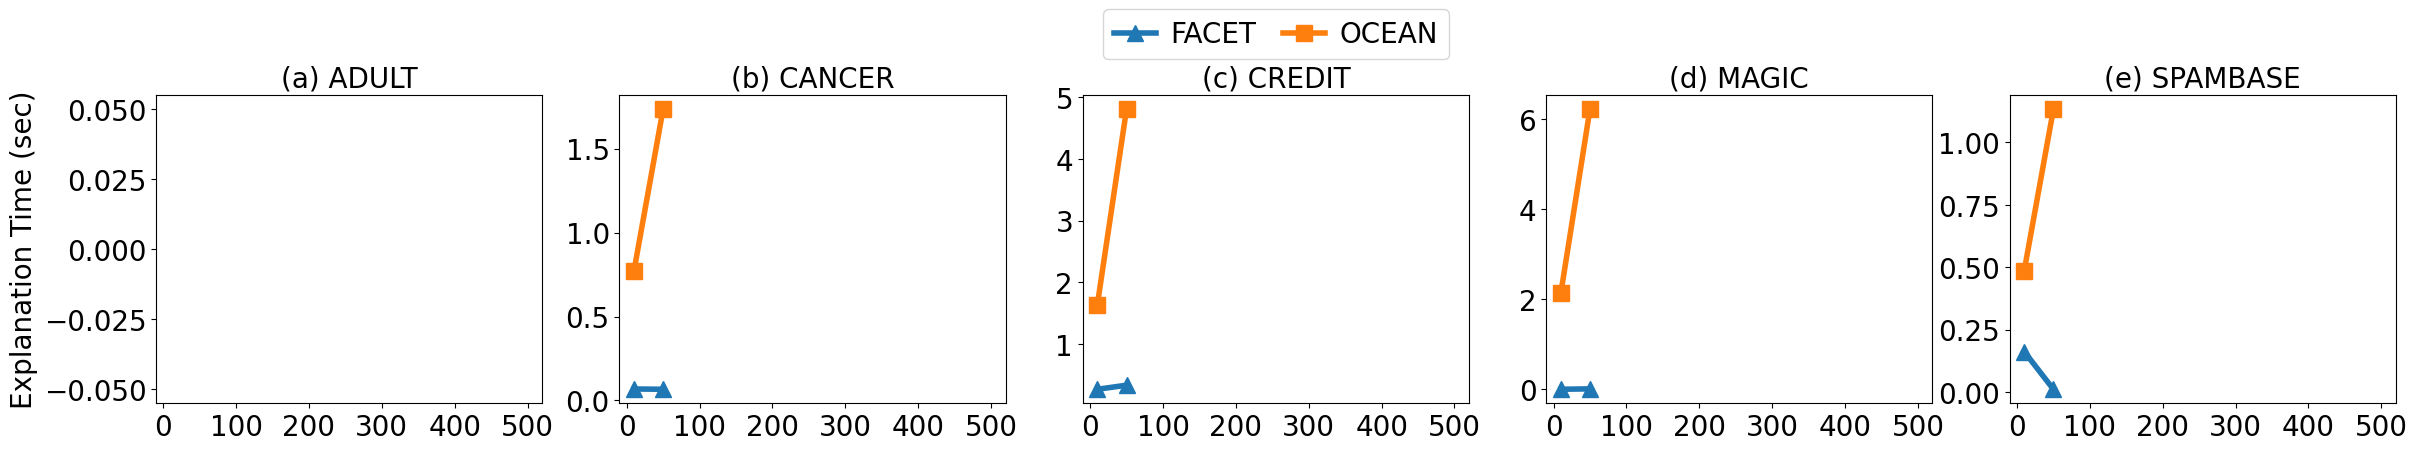

In [49]:
# ######### MAIN PAPER DATASETS - EXPLANATION TIME
datasets = ["adult", "cancer", "credit", "magic", "spambase"]
# axis ranges
# yticks_multi = [np.arange(0, 720, 100,), np.arange(0, 65, 10), np.arange(0, 640, 100), np.arange(0, 161, 20), np.arange(0, 61, 10)]
# yrange_multi = [[-3, 725], [-1.5, 66], [-20, 640], [-4, 165], [-3, 60]]
yticks_multi = None
yrange_multi = None
# create the plot
render_plot_ax(datasets, xfeature="n_trees", yfeature="sample_time", xlabel="T (Number of Trees)", ylabel="Explanation Time (sec)", title="Explanation Time vs Num Trees", save_name=fig_save_name_1, xrange=[-10, 520], yrange_multi=yrange_multi, yticks_multi=yticks_multi, ytick_format="{:d}")

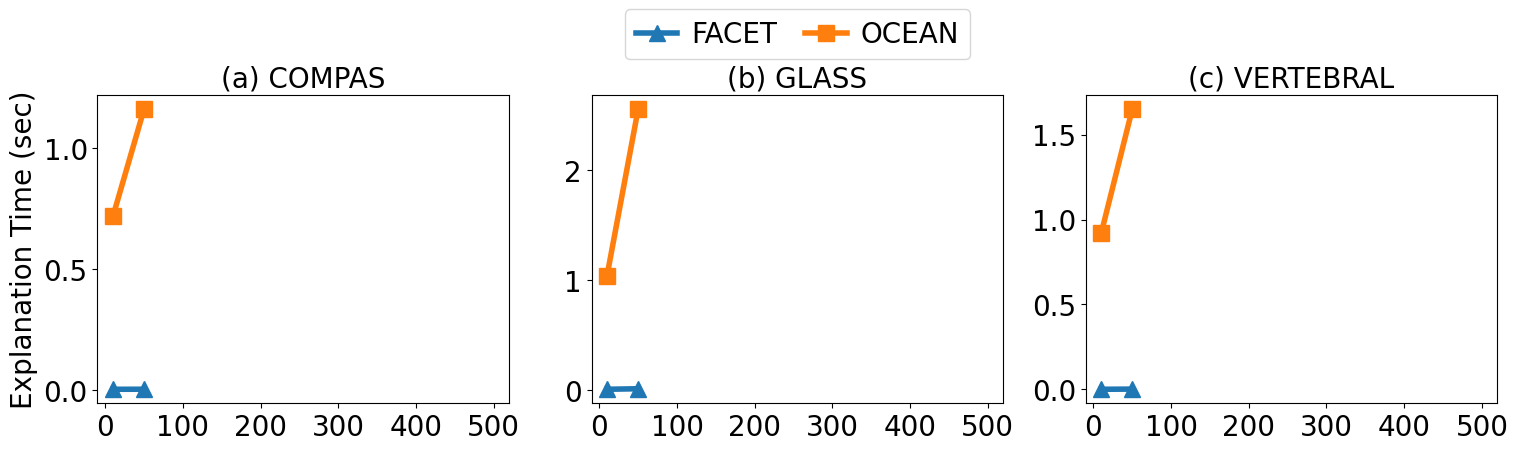

In [50]:
# ######### APPENDIX DATASETS - EXPLANATION TIME
datasets_apdx = ["compas", "glass", "vertebral"]
# axis ranges
# yticks_multi = [np.arange(0, 720, 100,), np.arange(0, 65, 5), np.arange(0, 37, 5), np.arange(0, 161, 20), np.arange(0, 61, 10)]
# yrange_multi = [[-3, 470], [-1.5, 23], [-1.5, 36], [-4, 165], [-3, 60]]
yticks_multi = None
yrange_multi = None
# create the plot
render_plot_ax(datasets_apdx, xfeature="n_trees", yfeature="sample_time", xlabel="T (Number of Trees)", ylabel="Explanation Time (sec)", title="Explanation Time vs Num Trees", save_name=fig_save_name_1 + "_apdx", xrange=[-10, 520], yrange_multi=yrange_multi, yticks_multi=yticks_multi, ytick_format="{:d}")

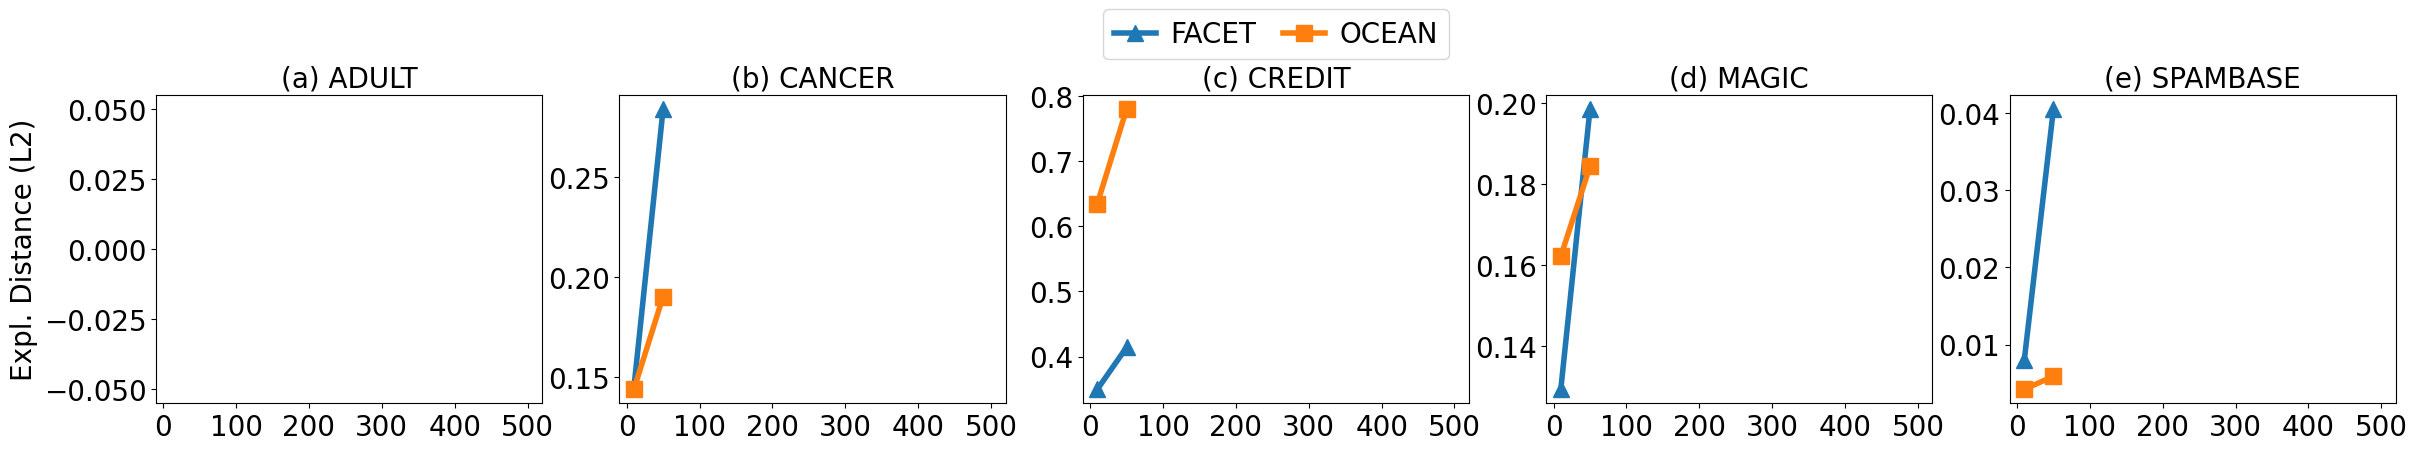

In [51]:
# ###### MAIN PAPER DATASETS - EXPLANTION DISTANCE
datasets = ["adult", "cancer", "credit", "magic", "spambase"]
# axis parameters
# yticks_multi = [np.arange(0, 0.45, 0.05), np.arange(0, 0.46, 0.05), np.arange(0, 0.46, 0.05), np.arange(0.1, 0.19, 0.02), np.arange(0, 0.13, 0.02)]
# yrange_multi = [[0.06, 0.42], [0.14, 0.47], [0.06, 0.47], [0.09, 0.185], [-0.005, 0.13]]
yticks_multi = None
yrange_multi = None
# create the parameters
render_plot_ax(datasets, xfeature="n_trees", yfeature="avg_dist", xlabel="T (Number of Trees)", ylabel="Expl. Distance (L2)", title="Average Distance vs Num Trees", save_name=fig_save_name_2, xrange=[-10, 520], yticks_multi=yticks_multi, yrange=[None, None], yrange_multi=yrange_multi)

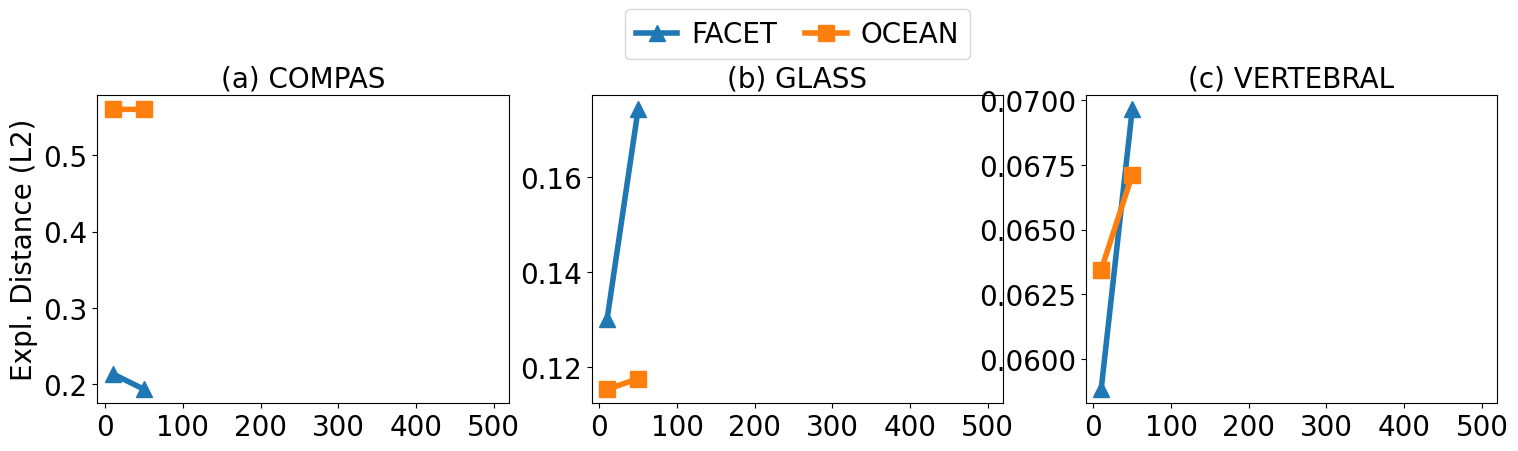

In [52]:
# ###### APPENDIX DATASETS - EXPLANTION DISTANCE
datasets_apdx = ["compas", "glass", "vertebral"]
# axis parameters
yticks_multi = None
yrange_multi = None
# create the parameters
render_plot_ax(datasets_apdx, xfeature="n_trees", yfeature="avg_dist", xlabel="T (Number of Trees)", ylabel="Expl. Distance (L2)", title="Average Distance vs Num Trees", save_name=fig_save_name_2 + "_apdx", xrange=[-10, 520], yticks_multi=yticks_multi, yrange=[None, None], yrange_multi=yrange_multi)